### Notebook to try out some algorithms for multi-timebin decoding
- motivation: in both looking at inter-trial interval and feedback periods, wonder if including multiple time bins could help improve decoding accuracy.
- Models to try out: 
  - flat decoder, treat time bins as independent
  - 1d convolution across time
  - RNN (maybe as the 599N project?)
  - (maybe)
- Going to start with fb period as a baseline

In [10]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter

from models.model_wrapper import ModelWrapper
from models.multinomial_logistic_regressor import (
    MultinomialLogisticRegressor, 
    NormedMultinomialLogisticRegressor,
    NormedDropoutMultinomialLogisticRegressor,
)
from models.value_models import ValueNormedDropoutModel, ValueDropoutModel, ValueDropoutNormedModel
from models.multi_layer import MultiLayer

from models.trainer import Trainer
import pickle

from sklearn.cluster import KMeans
import plotly.express as px
from itertools import accumulate

import scipy.stats as stats

import torch

species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [4]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))


In [5]:
fb_firing_rates = firing_rates[(firing_rates.TimeBins >= 1.8) & (firing_rates.TimeBins < 2.3)]
len(fb_firing_rates.TimeBins.unique())

5

### Try out flattening first

In [13]:
train_accs_by_dropout = []
test_accs_by_dropout = []
for p_dropout in np.arange(0.0, 1.1, 0.1):
    num_neurons = len(fb_firing_rates.UnitID.unique())
    labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
    init_params = {"n_inputs": num_neurons * 5, "n_values": 12, "p_dropout": p_dropout}
    # init_params = {"n_inputs": num_neurons, "n_values": 12}

    trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=128)
    wrapped = ModelWrapper(ValueDropoutModel, init_params, trainer, labels)
    # wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = fb_firing_rates.rename(columns={mode: "Value"})
    labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

    random_splitter = KFoldSplitter(labels.TrialNumber.unique(), 5)

    train_accs, test_accs, shuffled, models = classifier_utils.evaluate_classifier(
        wrapped, inputs, labels, random_splitter, cards=shuffled_card_idxs
    )

    train_accs_by_dropout.append(np.mean(train_accs))
    test_accs_by_dropout.append(np.mean(test_accs))

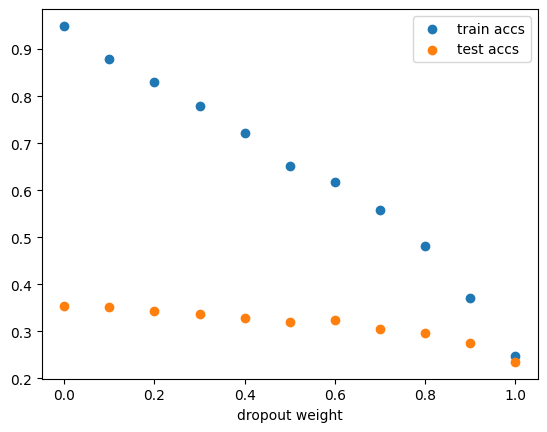

In [14]:
fig, ax = plt.subplots()
dropouts = np.arange(0.0, 1.1, 0.1)
ax.scatter(dropouts, train_accs_by_dropout, label="train accs")
ax.scatter(dropouts, test_accs_by_dropout, label="test accs")
ax.set_xlabel("dropout weight")
ax.legend()

### Test Normalize, then Dropout Model

In [6]:
train_accs_by_dropout = []
test_accs_by_dropout = []
for p_dropout in np.arange(0.0, 1.1, 0.1):
    num_neurons = len(fb_firing_rates.UnitID.unique())
    labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
    init_params = {"n_inputs": num_neurons * 5, "n_values": 12, "p_dropout": p_dropout}
    # init_params = {"n_inputs": num_neurons, "n_values": 12}

    trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=128)
    wrapped = ModelWrapper(ValueNormedDropoutModel, init_params, trainer, labels)
    # wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = fb_firing_rates.rename(columns={mode: "Value"})
    labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

    random_splitter = KFoldSplitter(labels.TrialNumber.unique(), 5)

    train_accs, test_accs, shuffled, models = classifier_utils.evaluate_classifier(
        wrapped, inputs, labels, random_splitter, cards=shuffled_card_idxs
    )

    train_accs_by_dropout.append(np.mean(train_accs))
    test_accs_by_dropout.append(np.mean(test_accs))

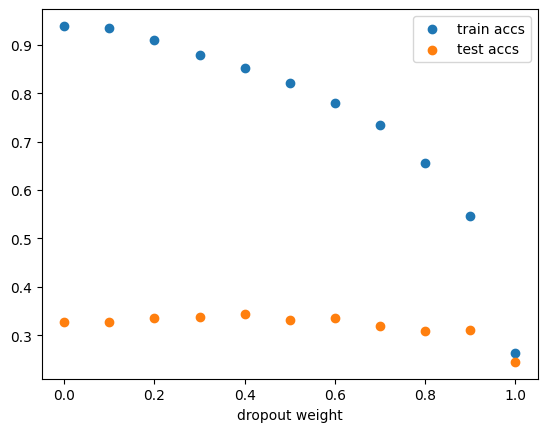

In [7]:
fig, ax = plt.subplots()
dropouts = np.arange(0.0, 1.1, 0.1)
ax.scatter(dropouts, train_accs_by_dropout, label="train accs")
ax.scatter(dropouts, test_accs_by_dropout, label="test accs")
ax.set_xlabel("dropout weight")
ax.legend()

### Test Dropout, Then Normalize model

In [11]:
dn_train_accs_by_dropout = []
dn_test_accs_by_dropout = []
for p_dropout in np.arange(0.0, 1.1, 0.1):
    num_neurons = len(fb_firing_rates.UnitID.unique())
    labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
    init_params = {"n_inputs": num_neurons * 5, "n_values": 12, "p_dropout": p_dropout}
    # init_params = {"n_inputs": num_neurons, "n_values": 12}

    trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=128)
    wrapped = ModelWrapper(ValueDropoutNormedModel, init_params, trainer, labels)
    # wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = fb_firing_rates.rename(columns={mode: "Value"})
    labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

    random_splitter = BlockSplitter(labels.TrialNumber.unique())

    train_accs, test_accs, shuffled, models = classifier_utils.evaluate_classifier(
        wrapped, inputs, labels, random_splitter, cards=shuffled_card_idxs
    )

    dn_train_accs_by_dropout.append(np.mean(train_accs))
    dn_test_accs_by_dropout.append(np.mean(test_accs))

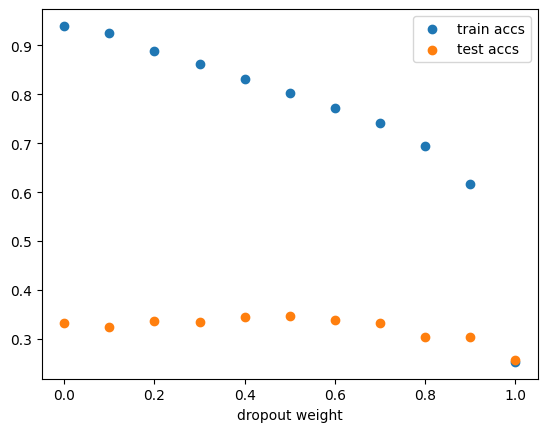

In [12]:
fig, ax = plt.subplots()
dropouts = np.arange(0.0, 1.1, 0.1)
ax.scatter(dropouts, dn_train_accs_by_dropout, label="train accs")
ax.scatter(dropouts, dn_test_accs_by_dropout, label="test accs")
ax.set_xlabel("dropout weight")
ax.legend()

### Compare Best Accuracy to per-timebin decoding

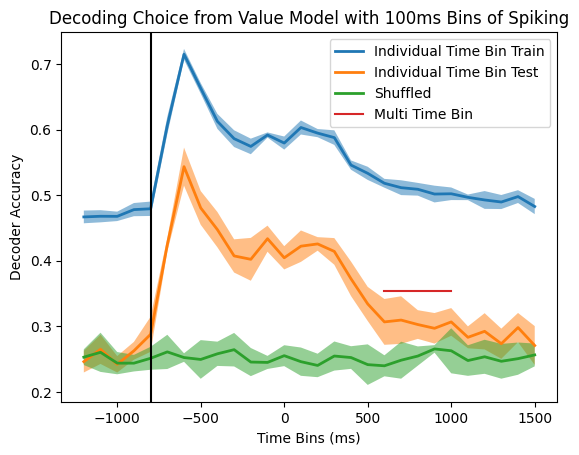

In [18]:
fig, axs = plt.subplots()

train_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_model_dropout_0p0_train_accs_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "rb"))
test_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_model_dropout_0p0_accs_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "rb"))
shuffled_accs = np.load(fs.open(f"l2l.pqz317.scratch/value_model_dropout_0p0_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "rb"))

visualization_utils.visualize_accuracy_across_time_bins(
    train_accs_by_bin,
    pre_interval, post_interval, 100,
    axs,
    label="Individual Time Bin Train",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    pre_interval, post_interval, 100,
    axs,
    label="Individual Time Bin Test",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs,
    pre_interval, post_interval, 100,
    axs,
    label="Shuffled",
    right_align=True
)
axs.plot(np.arange(600, 1100, 100), np.ones(5) * test_accs_by_dropout[0], label="Multi Time Bin")

axs.axvline(-800, color='k')
axs.set_xlabel("Time Bins (ms)")
axs.set_ylabel("Decoder Accuracy")
axs.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
axs.legend()

### What if using block splitter?

In [20]:
train_accs_by_dropout = []
test_accs_by_dropout = []
for p_dropout in np.arange(0.0, 1.1, 0.1):
    num_neurons = len(fb_firing_rates.UnitID.unique())
    labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
    init_params = {"n_inputs": num_neurons * 5, "n_values": 12, "p_dropout": p_dropout}
    # init_params = {"n_inputs": num_neurons, "n_values": 12}

    trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=128)
    wrapped = ModelWrapper(ValueDropoutModel, init_params, trainer, labels)
    # wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = fb_firing_rates.rename(columns={mode: "Value"})
    labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

    random_splitter = BlockSplitter(valid_beh)

    train_accs, test_accs, shuffled, models = classifier_utils.evaluate_classifier(
        wrapped, inputs, labels, random_splitter, cards=shuffled_card_idxs
    )

    train_accs_by_dropout.append(np.mean(train_accs))
    test_accs_by_dropout.append(np.mean(test_accs))

In [ ]:
fig, ax = plt.subplots()
dropouts = np.arange(0.0, 1.1, 0.1)
ax.scatter(dropouts, train_accs_by_dropout, label="train accs")
ax.scatter(dropouts, test_accs_by_dropout, label="test accs")
ax.set_xlabel("dropout weight")
ax.legend()